# Histograms of Oriented Gradients (HOG)

As we saw with the ORB algorithm, we can use keypoints in images to do keypoint-based matching to detect objects in images. These type of algorithms work great when we want to detect objects that have a lot of consistent internal features that are not affected by the background. 

For example, these algorithms work well for facial detection because faces have a lot of consistent internal features that don't get affected by the image background, such as the eyes, nose, and mouth. However, these type of algorithms don't work so well when attempting to do more general object recognition, for example, pedestrian detection in images. 

The reason is that people don't have consistent internal features, like faces do, because the body shape, and style of every person is different. This means that every person is going to have a different set of internal features, and so we need something that can generally describe a person.

One option is to try to detect pedestrians by their contours instead. Detecting objects in images by their contour (boundaries) is very challenging because we have to deal with the difficulties brought about by the constrast between background and foreground. For example, suppose we wanted to detect a pedestian in an image that is walking in front of a white building and she is wearing a white coat and black pants. Since the background of the image is mostly white, the black pants are going to have a very high contrast, but the coat, since it is white as well, is going to have very low contrast. In this case, detecting edges of pants is going to be easy but detecting the edges of the coat is going to be very difficult. This is where **HOG** comes in which was first introduced by Navneet Dalal and Bill Triggs in 2005.

The HOG algorihtm works by creating histograms of the distribution of gradient orientations in an image and then normalizing them in a very special way. This special normalization what makes HOG so effective at detecting the edges of objects even in cases where the contrast is very low. These normalized histograms are put together into a fearue vector, known as the HOG descriptor, that can be used to train a machine learning algorithm, such as SVM, to detect objects in images based on their boundaries (edges). Due to its great success and reliability, HOG has become one of the most widely used algorithms in computer vision for object detection.

Here, we will learn:
- How the HOG algorithm works
- How to use OpenCV to create a HOG descriptor
- How to visualize the HOG descriptor.

# The HOG Algorithm

It is based on creating histograms from the orientation of image gradients. The HOG algorithm is implemented in a series of steps:

1. Given the image of particular object, set a detection window (region of interest) that covers the entire object in the image.
2. Calculate the magnitude and direction of the gradient for each individual pixel in the detection window.
3. Divide the detection window into connected cells of pixels, with all cells being of the same size. The size of the cells is a free parameter and it is usually chosen so as to match the scale of the features that want to be detected. For example, in a 64x128 pixel detection windom, square cells 6 to 8 pixels wide are suitable for detecting human limbs.
4. Create a Histogram for each cell, by first grouping the gradient directions of all pixels in each cell into a particular number of orientation (angular) bins; and then adding up the gradient magnitudes of the gradients in each angular bin. The number of bins in the histogram is a free parameter and it is usually set to 9 angular bins.
5. Group adjacent cells into blocks. The number of cells in each block is a free parameter and all blocks must be of the same size. The distance between each block (known as the stride) is a free parameter but it is usually set to half the block size, in which case we will get overlapping blocks. The HOG algorithm has been shown empirically to work better with overlapping blocks.
6. Use the cells contained within each block to normalize in that block. If we have overlapping blocks this means that most cells will be normalized with respect to different blocks. Therefore, the same cell may have several different normalizations.
7. Collect all the normalized histograms from all the blocks into a single feature vector called the HOG descriptor.
8. Use the resulting HOG descriptor from many images of the same type of object to train a machine learning algorithm, such as an SVM, to detect those type of objects in image. For example, we could use the HOG descriptors from many images of pedestrians to train an SVM to detect pedestrians in images. The training is done with both positive and negative examples of the object we want to detect in the image.
9. Once the SVM has been trained, a sliding window approach is used to try to detect and locate objects in images. Detecting an object in the image entails finding the part of the image that looks similar to the HOG pattern learned by the SVM.

# Why the HOG Algorithm Works

HOG creates histograms by adding the magnitude of the gradients in particular orientations in localized portions of the image called cells. By doin this, we guarantee that stronger gradients will contribute more to the magnitude of their respective angular bin, while the effects of the weak and randomly oriented gradients resulting from noise are minimized. In this manner the histograms tell us the dominant gradient orientation of each cell.

## Dealing with contrast

Now, the magnitude of the dominant orientation can vary widely due to variantions in local illumination and the contrast between the background and the foreground.

To account for the background-foreground contrast differences, the HOG algorithm tries to detect edges locally. In order to do this, it defines groups of cells, called **blocks**, and normalizes the histograms using this local group of cells. By normalizing locally, the HOG algorithm can detect the edges in each block very reliably; this is called **block normalization**.

In addition to using block normalization, the HOG algorithm also uses overlapping blocks to increase its performance. So, each cell contributes several independent components to the final HOG descriptor, where each component corresponds to a cell being normalized with respect to a different block. This may seem reduntant but, it has been shown empirically that by normalizing each cell several times with respect to different local blocks, the performance of the HOG algorithm increases dramatically.

## Loading images and importing resources

The original image has shape:  (250, 250, 3)
The gray scale image has shape:  (250, 250)


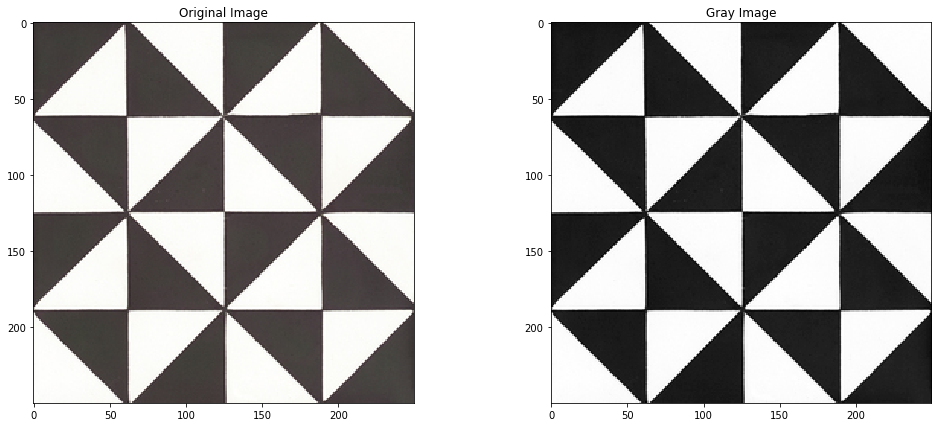

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set the default figure size
plt.rcParams['figure.figsize'] = [17.0, 7.0]

# Load the image
image = cv2.imread('./images/triangle_tile.jpeg')

# Convert the original image to RGB
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the original image to gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print('The original image has shape: ', original_image.shape)
print('The gray scale image has shape: ', gray_image.shape)

# Display the images
plt.subplot(121)
plt.imshow(original_image)
plt.title('Original Image')

plt.subplot(122)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Image')

plt.show()

 # Creating the HOG Descriptor
 
 We will use OpenCV's *HOGDescriptor* class to create the HOG Descriptor. The parameters:
 
 ```
 cv2.HOGDescriptor(
     win_size = (64, 128),
     block_size = (16, 16),
     block_stride = (8, 8),
     cell_size = (8, 8),
     nbins = 9,
     win_sigme = DEFAULT_WIN_SIGMA,
     threshold_L2hys = 0.2,
     gamma_correction = true,
     nlevels = DEFAULT_NLEVELS
 )
 ```
 
 - **win_size** - Size
 
 Size of detection window in pxiels (width, height). Defines the region of interest. Must be an integer multiple of cell size.
 
 - **block_size** - Size
 
 Block size in pixels (width, height). Defines how many cells are in each block. Must be an integer multiple of cell size and it must be smaller than the detection window. The smaller the block the finer detail we will get.
 
 - **block_stride** - Size
 
 Block stride in pixels (horizontal, vertical). It must be an integer of multiple of cell size. It defines the distance between adjecent blocks. Longer it makes the algorithm run faster (because less blocks are evaluated) but the algorithm may not perform as well.
 
 - **cell_size** - Size
 
 Cell size in pixel (width, height). Determines the size of our cell. The smaller the cell, the finer detail we will get.
 
 - **nbins** - int
 
 Number of bins for the histograms. Determines the number of angular bins used to make the histograms. With more bins you capture more gradient directions. HOG uses unsigned gradients, so the angular bins will have values between 0 and 180 degrees.
 
 - **win_sigma** - double
 
 Gaussian smoothing window parameter. The performance of the HOG algorithm can be improved by the smoothing the pixels near edges of the blocks by applying a Gaussian spatial window to each pixel before computing the histograms.
 
 - **threshold_L2hys** - double
 
 L2-Hys normalization method shrinkage. It is used to normalize the blocks and it consists of an L2-norm followed by clipping and a renormalization. The clipping limits the max value of the descriptor vector for each block to hae the value of the given threshold (0.2 by default). 
 
 - **gamma_correction** - bool
 
 Flag to specify whether the gamma correction preprocessing is required or not. It slightly increase the performance of the HOG algorithm.
 
 - **nlevels** - int
 
 Max number of detection window.
 
 The first few arguments *(block_size, block_stride, cell_size and nbins)* are probably the ones we are most likely to change.
 
 After using this functions, we will then use *.compute(image)* method to compute HOG descriptor (feature vector) for the given image.

In [4]:
# Specify the parameters for our HOG descriptor

cell_size = (6, 6)
num_cells_per_block = (2, 2)
block_size = ( num_cells_per_block[0] * cell_size[0],
               num_cells_per_block[1] * cell_size[1])

x_cells = gray_image.shape[1] // cell_size[1]
y_cells = gray_image.shape[0] // cell_size[0]

h_stride = 1
v_stride = 1

block_stride = (cell_size[0] * h_stride,
                cell_size[1] * v_stride)

num_bins = 9

win_size = (x_cells * cell_size[0],
            y_cells * cell_size[1])

print('\n The gray scale image has shape: ', 
      gray_image.shape)

# Set the parameters of the HOG descriptor using
# the variables defined above
hog = cv2.HOGDescriptor(win_size,
                        block_size,
                        block_stride,
                        cell_size,
                        num_bins)

# Compute the HOG Descriptor 
hog_descriptor = hog.compute(gray_image)


 The gray scale image has shape:  (250, 250)


# Number of Elements in the HOG Descriptor

The resulting HOG Descriptor (feature vector), contains the normalized histograms from all cells from all blocks in the detection window concatenated in one long vector. Therefore, the size of the HOG feature vector will be given by the total number of blocks in the detection window, multiplied by the number of cells per block, times the number of orientation bins:

total_elemets = (total_number_of_blocks) x (number_cells_per_block) x (number_of_bins)

${Total}_i = \frac{{cells}_i - {num-cells-per-block}_i}{N_i} + 1 ; for i = x,y $

Where $cell_x$ is the total number of cells along the width of the detection window, and ${cells}_y$ is the total number of cells along the height of the detection window. And $N_x$ is the horizontal block stride in units of *cell_size* and $N_y$ is the vertical block stride in units of *cell_size*.

In [29]:
# Calculate the notal number of blocks along the width
tot_bx = np.uint32(((x_cells 
                     - num_cells_per_block[0])
                     / h_stride)  + 1)

# Calculate the notal number of blocks along the height
tot_by = np.uint32(((y_cells 
                     - num_cells_per_block[1])
                     / v_stride)  + 1)

# total number of elements
tot_els = (tot_bx) * (tot_by) * num_cells_per_block[0] \
        * num_cells_per_block[1] * num_bins

print("\nThe total number of elements in the HOG Feature Vector should be: ",
     tot_bx, 'x',
     tot_by, 'x',
     num_cells_per_block[0], 'x',
     num_cells_per_block[1], 'x',
     num_bins, '=',
     tot_els)

print('\n The HOG Descriptor has shape: ', \
                      hog_descriptor.shape)


The total number of elements in the HOG Feature Vector should be:  40 x 40 x 2 x 2 x 9 = 57600

 The HOG Descriptor has shape:  (57600, 1)


# Visualizing The HOG Desriptor

We can visualize the HOG Descriptor by plotting the histogram with each cell as a collection of vectors. To do this, we will plot each bin in the histogram as a single vector whose magnitude is given by the height of the bin and its ortientation is given by the angular bin that is associated with. Since any given cell might have multiple histograms associated with it, due to the overlapping blocks, we will choose to average all the histograms for each cell to produce a single histogram for each cell.

We will start by reshaping the HOG Descriptor in order to make our calculations easier. We will then compute the average histogram of each cell and finally we will convert the histogram bins into vectors. Once we have the vectors, we plot the corresponding vectors for each cell in an image.

The code below produces an interactive plot so that you can interact with the figure. It contains:
- the grayscale image,
- the HOG Descriptor
- a zoomed-in portion of the HOG Descriptor
- the histogram of the selected cell

You can click anywhere on the gray scale image or the HOG Descriptor image to select a particular cell. Once you click on either imager a *magenta* rectangle will appear showing the cell you selected. 

The feature vector has shape: (57600, 1)
The reshaped feature vector has shape: (40, 40, 2, 2, 9)
The average gradient array has shape:  (41, 41, 9)


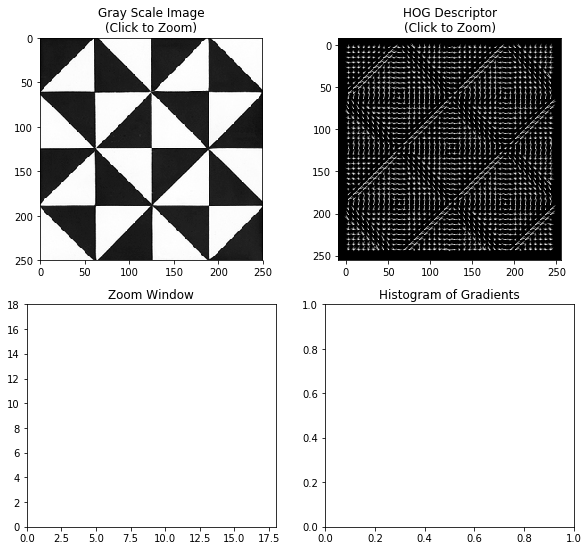

In [33]:
%matplotlib inline

import copy
import matplotlib.patches as patches

# Set the default figure size
plt.rcParams['figure.figsize'] = [9.8, 9]

# Reshape the feature vector to [blocks_y, blocks_x, num_cells_per_block_x, num_cells_per_block_y, num_bins].
# The blocks_x and blocks_y will be transposed so that the first index (blocks_y) referes to the row number
# and the second index to the column number. This will be useful later when we plot the feature vector, so
# that the feature vector indexing matches the image indexing.
hog_descriptor_reshaped = hog_descriptor.reshape(tot_bx,
                                                 tot_by,
                                                 num_cells_per_block[0],
                                                 num_cells_per_block[1],
                                                 num_bins).transpose((1, 0, 2, 3, 4))

# Print the shape of the feature vector for reference
print('The feature vector has shape:', hog_descriptor.shape)

# Print the reshaped feature vector
print('The reshaped feature vector has shape:', hog_descriptor_reshaped.shape)

# Create an array that will hold the average gradients for each cell
ave_grad = np.zeros((y_cells, x_cells, num_bins))

# Print the shape of the ave_grad array for reference
print('The average gradient array has shape: ', ave_grad.shape) 

# Create an array that will count the number of histograms per cell
hist_counter = np.zeros((y_cells, x_cells, 1))

# Add up all the histograms for each cell and count the number of histograms per cell
for i in range (num_cells_per_block[0]):
    for j in range(num_cells_per_block[1]):
        ave_grad[i:tot_by + i,
                 j:tot_bx + j] += hog_descriptor_reshaped[:, :, i, j, :]
        
        hist_counter[i:tot_by + i,
                     j:tot_bx + j] += 1

# Calculate the average gradient for each cell
ave_grad /= hist_counter
   
# Calculate the total number of vectors we have in all the cells.
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
deg = np.linspace(0, np.pi, num_bins, endpoint = False)

# Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
# equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram). 
# To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
# image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
# cells in the image. Create the arrays that will hold all the vector positons and components.
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the 
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            counter = counter + 1

# Create the bins in degress to plot our histogram. 
angle_axis = np.linspace(0, 180, num_bins, endpoint = False)
angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)

# Create a figure with 4 subplots arranged in 2 x 2
fig, ((a,b),(c,d)) = plt.subplots(2,2)

# Set the title of each subplot
a.set(title = 'Gray Scale Image\n(Click to Zoom)')
b.set(title = 'HOG Descriptor\n(Click to Zoom)')
c.set(title = 'Zoom Window', xlim = (0, 18), ylim = (0, 18), autoscale_on = False)
d.set(title = 'Histogram of Gradients')

# Plot the gray scale image
a.imshow(gray_image, cmap = 'gray')
a.set_aspect(aspect = 1)

# Plot the feature vector (HOG Descriptor)
b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
b.invert_yaxis()
b.set_aspect(aspect = 1)
b.set_facecolor('black')

# Define function for interactive zoom
def onpress(event):
    
    #Unless the left mouse button is pressed do nothing
    if event.button != 1:
        return
    
    # Only accept clicks for subplots a and b
    if event.inaxes in [a, b]:
        
        # Get mouse click coordinates
        x, y = event.xdata, event.ydata
        
        # Select the cell closest to the mouse click coordinates
        cell_num_x = np.uint32(x / cell_size[0])
        cell_num_y = np.uint32(y / cell_size[1])
        
        # Set the edge coordinates of the rectangle patch
        edgex = x - (x % cell_size[0])
        edgey = y - (y % cell_size[1])
        
        # Create a rectangle patch that matches the the cell selected above        
        rect = patches.Rectangle((edgex, edgey),
                                  cell_size[0], cell_size[1],
                                  linewidth = 1,
                                  edgecolor = 'magenta',
                                  facecolor='none')
        
        # A single patch can only be used in a single plot. Create copies
        # of the patch to use in the other subplots
        rect2 = copy.copy(rect)
        rect3 = copy.copy(rect)
        
        # Update all subplots
        a.clear()
        a.set(title = 'Gray Scale Image\n(Click to Zoom)')
        a.imshow(gray_image, cmap = 'gray')
        a.set_aspect(aspect = 1)
        a.add_patch(rect)

        b.clear()
        b.set(title = 'HOG Descriptor\n(Click to Zoom)')
        b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        b.invert_yaxis()
        b.set_aspect(aspect = 1)
        b.set_facecolor('black')
        b.add_patch(rect2)

        c.clear()
        c.set(title = 'Zoom Window')
        c.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 1)
        c.set_xlim(edgex - cell_size[0], edgex + (2 * cell_size[0]))
        c.set_ylim(edgey - cell_size[1], edgey + (2 * cell_size[1]))
        c.invert_yaxis()
        c.set_aspect(aspect = 1)
        c.set_facecolor('black')
        c.add_patch(rect3)

        d.clear()
        d.set(title = 'Histogram of Gradients')
        d.grid()
        d.set_xlim(0, 180)
        d.set_xticks(angle_axis)
        d.set_xlabel('Angle')
        d.bar(angle_axis,
              ave_grad[cell_num_y, cell_num_x, :],
              180 // num_bins,
              align = 'center',
              alpha = 0.5,
              linewidth = 1.2,
              edgecolor = 'k')

        fig.canvas.draw()

# Create a connection between the figure and the mouse click
fig.canvas.mpl_connect('button_press_event', onpress)
plt.show()